
<div style="border:1px solid black; padding:20px 20px;text-align: justify;text-justify: inter-word">
    <strong>Miniproject - Path Planning<br/> </strong><br/><br/>
    <span style="text-decoration:underline;font-weight:bold;">How to use this notebook?</span><br/>
    This notebook is made of text cells and code cells. The code cells have to be <strong>executed</strong> to see the result of the program. To execute a cell, simply select it and click on the "play" button (<span style="font: bold 12px/30px Arial, serif;">&#9658;</span>) in the tool bar just above the notebook, or type <code>shift + enter</code>. It is important to execute the code cells in their order of appearance in the notebook.<br/>
You can make use of the table of contents to navigate easily between sections.
</div>


In [35]:
!pip install --upgrade tdmclient

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

## Map Initialisation

## Implementing the Algorithm

In [36]:
from djikstra import djikstra_algo
from kalmanfilter import KalmanFilter

dt = 0.1
point = (6.5,6.5)
speed_to_mms = 19
q_cam = 1
q_gnd = 1
r_cam = 1
r_gnd = 1
KF = KalmanFilter(dt, point, speed_to_mms, q_cam, q_gnd, r_cam, r_gnd)


TypeError: compute_Q() takes 3 positional arguments but 4 were given

[[0 0 1 1 2 3 3]
 [0 1 1 2 2 2 3]]



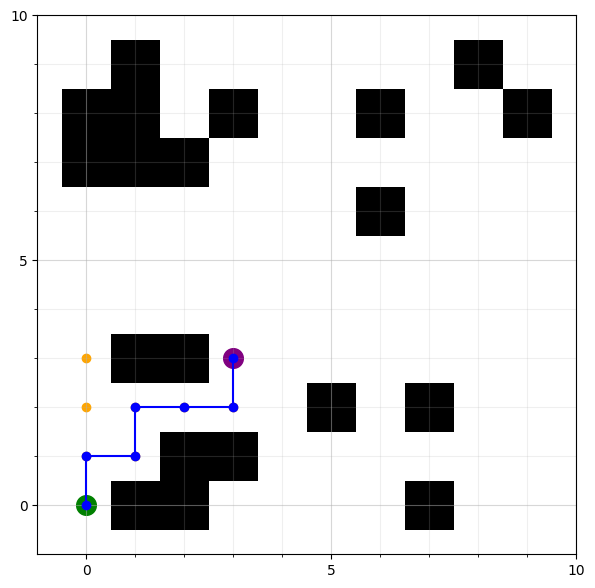

In [27]:
# Initialize the parameters
max_val_x = 10 # Size of the map
max_val_y = 10 # Size of the map
start = (0,0)
goal = (3,3)
np.random.seed(0) # To guarantee the same outcome on all computers
data = np.random.rand(max_val_x, max_val_y) * 20 # Create a grid of 50 x 50 random values

shortest_path = djikstra_algo(data,start,goal)
print(shortest_path)
print()

In [32]:
#The exclamation point (!) allow to execute a terminal command in the notebook:
!python3 -m tdmclient list

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [33]:
# Import tdmclient Notebook environment:
import tdmclient.notebook
await tdmclient.notebook.start()

ModuleNotFoundError: No module named 'tdmclient'

In [ ]:
#from tdmclient import ClientAsync
#client = ClientAsync()
#node = await client.wait_for_node()
#await node.lock()

In [30]:
@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed   



NameError: name 'tdmclient' is not defined

In [21]:
@tdmclient.notebook.sync_var
def get_turn(x,y,orientation):
    if x==1 and y==0:
        dir = 0
    elif x==0 and y==1:
        dir = 1
    elif x==-1 and y==0:
        dir = 2
    elif x==0 and y==-1:
        dir = 3
    else:
        dir = orientation
    new_orientation = dir - orientation
    if abs(new_orientation)>2:
        return (new_orientation)-4*np.sign(new_orientation)
    else:
        return new_orientation

NameError: name 'tdmclient' is not defined

In [20]:
def kalman_adjust(dx,dy,kalman_pos_x,kalman_pos_y,orientation):
   x_mm = dx*125-kalman_pos_x
   y_mm = dy*125-kalman_pos_y
   if (orientation == 0 or orientation == 2):
      turn = get_turn(0,np.sign(y_mm),orientation)
      adjust = turn*(y_mm)
   else:
      turn = get_turn(np.sign(x_mm),0,orientation)
      adjust = turn*(x_mm)
   print("adjust = ",adjust)
   return adjust

In [19]:
import time
orientation = 0
jump = False
jump_x,jump_y = 0,0
x = start[0]
y = start[1]
turn_speed = 0
kalman_pos_x, kalman_pos_y = 0,0
ajdust = 0

for dx,dy in np.transpose(shortest_path):
    if jump:
        x = dx      #actualize the coordinates of the robot
        y = dy      #actualize the coordinates of the robot
        if jump_x == dx and jump_y == dy:
            jump = False
        continue
    
    if False: #camera_check()
        angle = camera_angle #angle of the robot
        ajdust_angle = angle-orientation
        motors(-100*np.sign(ajdust_angle), 100*np.sign(ajdust_angle), verbose=True) #test with lower speed value
        time.sleep(5*abs(adjust_angle))
        motors(0, 0, verbose=False)
    elif False :#local_nav_error()
        jump_x,jump_y = 0,0#local_nav_correct(x,y,shortest_path)
    else:
        turn = get_turn(dx-x,dy-y,orientation)
        orientation = orientation + turn
        turn_speed = int(100*np.sign(turn))
        motors(-turn_speed, turn_speed, verbose=True) #test with lower speed value
        time.sleep(5*abs(turn)//2)
        if (((dx-x)!=0) | ((dy-y)!=0)):
            kalman_pos_x,kalman_pos_y= KF.filter(isCamOn, pos_from_cam, orientation, 100, gnd, gnd_prev, 
               transition_threshold)
            adjust = kalman_adjust(dx-x,dy-x,kalman_pos_x,kalman_pos_y,orientation)
            kalman_pos_x = int(100 - adjust) #je reutilise juste les variables
            kalman_pos_y = int(100 + adjust)
            motors(kalman_pos_x, kalman_pos_y, verbose=True) #test with lower speed value
            time.sleep(5)
        motors(0, 0, verbose=False)
        x = dx      #actualize the coordinates of the robot
        y = dy      #actualize the coordinates of the robot


motors(0, 0, verbose=True)

NameError: name 'get_turn' is not defined

In [ ]:
import time
motors(100, 100, verbose=True) #test with lower speed value
time.sleep(5) 
motors(0, 0, verbose=True)

		 Setting speed :  100 100
		 Setting speed :  0 0


In [ ]:
aw(node.unlock())